In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.append('..')

In [18]:
from visualization.live_visualization import LiveVisualization
from visualization.order_params_visualization import OrderParamsVisualization
from state import State
import os
import json
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from utils.order_parameters import (
    calculate_var_r,
    calculate_avg_r,
    potential_M_N,
    angular_distance,
    calculate_S,
    centroid_m
)
import colorsys
from matplotlib.ticker import MultipleLocator

In [19]:
results_dir = 'results/log/'
swarm_results_dir = 'results/log/swarm/final/'

In [20]:
def state_from_json(s, params):
    #print(s)
    params.update({
        'phase_levels_number': s['phase_levels_number'],
        'orientation_mode': s['orientation_mode'],
        'synchronized': False,
        'small_phase_steps': 100,
    })
    state = State(
        phase=s['phase'],
        position=np.array(s['position']),
        #phase_level=s['phase_level'],
        #phase_levels_number=s['phase_levels_number'],
        #small_phase=s['small_phase'],
        velocity=np.array(s['velocity']),
        #orientation_mode=s['orientation_mode'],
        params=params,
    )
    state.phase_level = s['phase_level']
    state.small_phase = s['small_phase']
    return state

def calculate_potential(states):
    N = len(states)
    potentials = []
    a = 0.75
    r = 2
    d = 0.2
    
    for i, s1 in enumerate(states):
        pot = 0
        x1 = s1.position
        for s2 in states[:i] + states[i+1:]:
            x2 = s2.position
            pot += a * np.linalg.norm(x2-x1)**2/2 - r * np.log(np.linalg.norm(x2-x1) - d)
        potentials.append(pot/N)
    return potentials

In [21]:
def parse_params_from_filename(filename):
    params = {}
    param_string = filename[:-5].split(':')[-1]
    param_strings = param_string.split(',')
    for ps in param_strings:
        param_name, value_string = ps.split('=')
        if param_name == 'M':
            value = int(value_string)
        else:
            value = float(value_string)
        params[param_name] = value
    return params


In [22]:
ts = {}
var_rs = {}
time_coord_potentials = {}
angular_distances = {}
Ss = {}
centroids = {}
instants = {}
snapshots = {}
potentials = {}

In [23]:
filenames = os.listdir(results_dir)
filenames_swarm = os.listdir(swarm_results_dir)

In [24]:
for filename in filenames:
    print(filename)
    params = parse_params_from_filename(filename)
    with open(f'{results_dir}{filename}') as f:
        result = json.load(f)
        history = result['states']
        ts[filename] = []
        var_rs[filename] = []
        time_coord_potentials[filename] = []
        angular_distances[filename] = []
        Ss[filename] = []
        centroids[filename] = []
        instants[filename] = []
        snapshots[filename] = {}
        for t, states in history:
            for k, s in states.items():
                states[k] = state_from_json(s, params)
            
            ts[filename].append(t)

            # calculate new parameters
            var_rs[filename].append(calculate_var_r(list(states.values())))
            time_coord_potentials[filename].append(
                potential_M_N(params['K'], params['M'],
                              list(states.values()))
            )
            angular_distances[filename].append(angular_distance(
                params['M'], states.values())
            )
            Ss[filename].append(calculate_S(states.values()))
            phases = [
                s.phase_level / s.phase_levels_number for s in states.values()
            ]
            centroids[filename].append(centroid_m(1, phases))
            snapshots[filename][t] = states
        times = ts[filename]
        instants[filename] = [times[0], times[int(len(times)/3)], times[-1]]
        

2020-07-01 14:01:19.668503:J=1.4,K=1,M=12.json
2020-07-01 14:04:02.967035:J=1.5,K=1,M=6.json
2020-07-01 13:58:59.822318:J=0.1,K=1,M=1.json
2020-07-01 14:00:24.226203:J=-1,K=0.2,M=3.json
2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json
cfs-2020-07-29 08:15:18.328682:J=0.1,K=1,M=1.json
swarm


ValueError: not enough values to unpack (expected 2, got 1)

In [25]:
datafiles = {
    'static-sync': '2020-07-01 13:58:59.822318:J=0.1,K=1,M=1.json',
    'static-async': '2020-07-01 14:00:24.226203:J=-1,K=0.2,M=3.json',
    'splintered-phase-wave': '2020-07-01 14:16:18.622647:J=1.5,K=1,M=4.json',
    'static-phase-wave': '2020-07-01 14:01:19.668503:J=1.4,K=1,M=12.json',
    # 'static-phase-wave': '2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json',
    'cfs-static-sync': 'cfs-2020-07-29 08:15:18.328682:J=0.1,K=1,M=1.json',
}

In [26]:
#tmp = ts['2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json']
#instants['2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json'] = [tmp[0], tmp[int(len(tmp)/2)], tmp[-1]]
tmp = ts['2020-07-01 14:01:19.668503:J=1.4,K=1,M=12.json']
instants['2020-07-01 14:01:19.668503:J=1.4,K=1,M=12.json'] = [tmp[0], tmp[int(len(tmp)/2)], tmp[-1]]
tmp = ts['2020-07-01 13:58:59.822318:J=0.1,K=1,M=1.json']
instants['2020-07-01 13:58:59.822318:J=0.1,K=1,M=1.json'] = [tmp[0], tmp[int(len(tmp)/4)-2], tmp[-2]]
tmp = ts['2020-07-01 14:00:24.226203:J=-1,K=0.2,M=3.json']
instants['2020-07-01 14:00:24.226203:J=-1,K=0.2,M=3.json'] = [tmp[0], tmp[int(len(tmp)/2)], tmp[-1]]
tmp = ts['2020-07-01 14:16:18.622647:J=1.5,K=1,M=4.json']
instants['2020-07-01 14:16:18.622647:J=1.5,K=1,M=4.json'] = [tmp[0], tmp[int(len(tmp)/4)+2], tmp[-1]]
tmp = ts['cfs-2020-07-29 08:15:18.328682:J=0.1,K=1,M=1.json']
instants['cfs-2020-07-29 08:15:18.328682:J=0.1,K=1,M=1.json'] = [tmp[0], tmp[int(len(tmp)/2)], tmp[-1]]


KeyError: '2020-07-01 14:16:18.622647:J=1.5,K=1,M=4.json'

In [27]:
tmp = ts['2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json']
states = snapshots['2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json'][tmp[-1]].values()
phases2pi = np.array([s.phase_level / s.phase_levels_number * 2 * np.pi for s in states])
positions = np.array([s.position for s in states])
center = np.average(positions, axis=0)
print(center)
positions_respect_center = positions - center
print(np.linalg.norm(positions_respect_center, axis=1))
angular_positions = np.array(
    [np.arctan2(p[1], p[0]) for p in positions_respect_center]
)
N = len(states)
print((phases2pi - angular_positions)% (2* np.pi))
Splus = np.absolute(
    1/N * sum(np.exp(1j * (phases2pi + angular_positions)))
)
Sminus = np.absolute(
    1/N * sum(np.exp(1j * (phases2pi - angular_positions)))
)
print(Splus, Sminus)

print([s.phase_level for s in snapshots['2020-08-20 10:16:16.380381:J=1.4,K=1,M=12.json'][tmp[-1]].values()])

[ 0.32567974 -0.78268753  0.        ]
[2.11258214 2.11528022 2.11450319 2.11508928 2.11428797 2.11548577
 2.11473583 2.11230103 2.11538063 2.11170469 2.11423454 2.11380224]
[4.33685709 4.33703586 4.33724478 4.33684318 4.33723074 4.33723589
 4.33685468 4.33724251 4.33702987 4.33705329 4.33705336 4.33684764]
0.00011207442336600203 0.9999999874371375
[23.0, 3.0, 7.0, 1.0, 5.0, 17.0, 11.0, 19.0, 15.0, 9.0, 21.0, 13.0]


In [28]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['legend.fancybox'] = True
#print(plt.rcParams.find_all('axes'))

plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.edgecolor'] = '#b3b3b3'
#plt.rcParams['figure.framealpha'] = 0.5
#plt.tick_params(left=False, bottom=False)
#matplotlib.style.use('default')
#matplotlib.style.use('seaborn-talk')
#matplotlib.style.use('seaborn-whitegrid')


KeyError: '2020-07-01 14:16:18.622647:J=1.5,K=1,M=4.json'

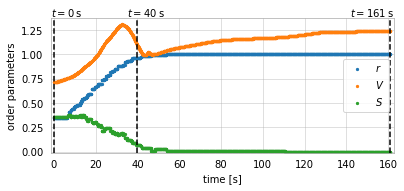

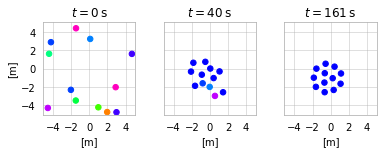

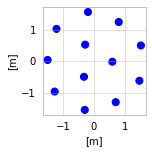

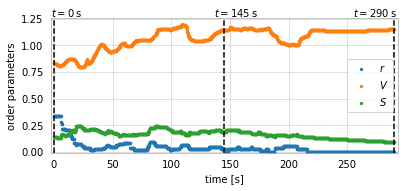

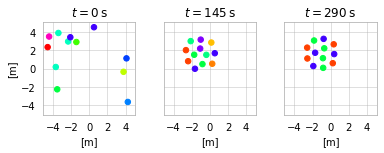

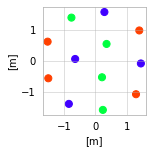

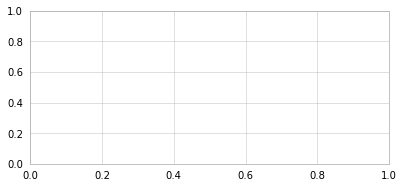

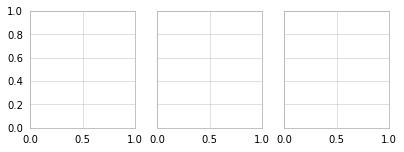

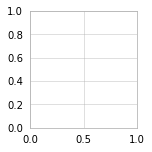

In [29]:
for pattern, filename in datafiles.items():
    fig, ax = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(5.5, 2.5)
    )
    #fig.suptitle(filename)
    fig2, s = plt.subplots(1, 3, constrained_layout=True, figsize=(5.5, 2), sharex=True, sharey=True)
    fig3, ax3 = plt.subplots(1, 1, constrained_layout=True, figsize=(2, 2))

    ax.set_axisbelow(True)
    ax.scatter(ts[filename], centroids[filename], s=5, label="$r$")
    ax.scatter(ts[filename], var_rs[filename], s=5, label="$V$")
    ax.scatter(ts[filename], Ss[filename], s=5, label="$S$")
    #ax.scatter(ts[filename], angular_distances[filename], s=5, label="Angular distance diff")
    #ax.scatter(ts[filename], time_coord_potentials[filename], s=5, label="Time coordination potential")
    #ax.spines['left'].set_visible(False)
    ax.set_ylim(ymin=-0.01)
    offsets = [ts[filename][-1]*0.01, ts[filename][-1]*0.03, ts[filename][-1]*0.12]
    ax.set_xlabel('time [s]')
    ax.set_ylabel('order parameters')
    correct_phase = 1 if pattern != 'static-phase-wave' else 0
    for i, t in enumerate(instants[filename]):
        ax.axvline(t, color='black', ls='--')
        ax.text(t-offsets[i], 1.01, f'$t={t:.0f}\\:$s', transform=ax.get_xaxis_transform())
        s[i].xaxis.set_major_locator(MultipleLocator(2))
        s[i].yaxis.set_major_locator(MultipleLocator(2))
        s[i].set_aspect('equal')
        xs = [s.position[0] for s in snapshots[filename][t].values()]
        ys = [s.position[1] for s in snapshots[filename][t].values()]
        cs = [colorsys.hsv_to_rgb((s.phase - correct_phase/s.phase_levels_number)%1, 1, 1) for s in snapshots[filename][t].values()]
        s[i].set_axisbelow(True)
        s[i].set_xlim((-5.1, 5.1))
        s[i].set_ylim((-5.1, 5.1))
        s[i].scatter(xs, ys, c=cs, s=30)
        s[i].set_title(f'$t={t:.0f}\\:$s')
        s[i].set_xlabel('[m]')
        
    s[0].set_ylabel('[m]')


    ax.legend(loc='center right')
    ax.set_xlim((-ts[filename][-1]*0.01, ts[filename][-1]*1.01))
    if not pattern.startswith('cfs'):
        fig.savefig(f'/home/agniewek/repos/papers/2020-journal/data/sim-op-{pattern}.pdf', transparent=True, bbox_inches="tight")
        fig2.savefig(f'/home/agniewek/repos/papers/2020-journal/data/sim-snapshots-{pattern}.pdf', transparent=True, bbox_inches="tight")
    else:
        fig.savefig(f'/home/agniewek/repos/papers/2020-journal/data/exp-op-{pattern}.pdf', transparent=True, bbox_inches="tight")
        fig2.savefig(f'/home/agniewek/repos/papers/2020-journal/data/exp-snapshots-{pattern}.pdf', transparent=True, bbox_inches="tight")
    
    if not pattern.startswith('cfs'):    
        t = instants[filename][-1]
        xs = np.array([s.position[0] for s in snapshots[filename][t].values()])
        xs = xs - np.average(xs)
        ys = np.array([s.position[1] for s in snapshots[filename][t].values()])
        ys = ys - np.average(ys)
        cs = [colorsys.hsv_to_rgb((s.phase - correct_phase/s.phase_levels_number)%1, 1, 1) for s in snapshots[filename][t].values()]
        ax3.scatter(xs, ys, c=cs, s=50)
        ax3.set_xlabel('[m]')
        ax3.set_ylabel('[m]')
        fig3.savefig(f'/home/agniewek/repos/papers/2020-journal/data/pattern-{pattern}.pdf', transparent=True, bbox_inches='tight')
    
    #fig, (ax_var_rs, ax_S, ax_ang_dist, ax_time_coord, ax_centroid) = plt.subplots(
    #    5, 1, sharex=True, constrained_layout=True, figsize=(5, 10)
    #)
    #fig.suptitle(filename)

    #ax_var_rs.scatter(ts[filename], var_rs[filename])
    #ax_S.scatter(ts[filename], Ss[filename])
    #ax_ang_dist.scatter(ts[filename], angular_distances[filename])
    #ax_time_coord.scatter(ts[filename], time_coord_potentials[filename])
    #ax_centroid.scatter(ts[filename], centroids[filename])
    
    #ax_var_rs.set_ylim(ymin=0)
    #ax_S.set_ylim(ymin=0)
    #ax_ang_dist.set_ylim(ymin=0)
    #ax_time_coord.set_ylim(ymin=0)
    #ax_centroid.set_ylim(ymin=0)
    
    #ax_var_rs.set_title("Distance from middle diff")
    #ax_S.set_title("S")
    #ax_ang_dist.set_title("Angular distance diff")
    #ax_time_coord.set_title("Time coordination potential")
    #ax_centroid.set_title("Synchronization centroid")


In [ ]:
def parse_vd_data(filenames):
    data = {
        'Ns': [],
        'Vds': [],
    }
    for f in filenames:
        f = f[:-4]
        d = f.split(':')
        model = d[0]
        N = int(d[1].split('=')[1])
        Vd = float(d[2].split('=')[1])
        if N == 4:
            continue
        data['Ns'].append(N)
        data['Vds'].append(Vd)
    return data


In [ ]:
res_dir = 'results/vd/'
final = sorted(os.listdir(res_dir))[-1]
vd_filenames = os.listdir(
    f'{res_dir}{final}'
)
vd_data = parse_vd_data(
    vd_filenames
)

In [ ]:
plt.scatter(vd_data['Ns'], vd_data['Vds'])

In [ ]:
vd_filenames
vd_data

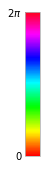

In [30]:
#import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
#import numpy as np

fig = plt.figure(figsize=(0.2, 2))

display_axes = fig.add_axes([0, 0, 1, 1]) #, projection='polar')

quant_steps = 256
norm = mpl.colors.Normalize(0, 2 * np.pi)
hsv = cm.get_cmap('hsv', quant_steps)
cmap = mpl.colors.ListedColormap(hsv(np.tile(np.linspace(0,1,quant_steps),1)))

cb = mpl.colorbar.ColorbarBase(display_axes,
                               cmap=cmap,
                               #norm=norm,
                               ticklocation='left',
                               ticks=[0, 1],
                               orientation='vertical'
                              )
cb.set_ticklabels(["0", "$2\pi$"], update_ticks=True)
cb.minorticks_off()
display_axes.tick_params(length=0) #top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
#cb.outline.set_visible(False)                                 
#display_axes.set_axis_off()
fig.savefig(f'/home/agniewek/repos/papers/2020-journal/data/colorbar.pdf', transparent=True, bbox_inches='tight')
plt.show()

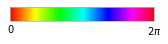

In [31]:
from matplotlib import cm
import matplotlib as mpl
#import numpy as np

fig = plt.figure(figsize=(2, 0.2))

display_axes = fig.add_axes([0, 0, 1, 1]) #, projection='polar')

quant_steps = 256
norm = mpl.colors.Normalize(0, 2 * np.pi)
hsv = cm.get_cmap('hsv', quant_steps)
cmap = mpl.colors.ListedColormap(hsv(np.tile(np.linspace(0,1,quant_steps),1)))

cb = mpl.colorbar.ColorbarBase(display_axes,
                               cmap=cmap,
                               #norm=norm,
                               ticklocation='bottom',
                               ticks=[0, 1],
                               orientation='horizontal'
                              )
cb.set_ticklabels(["0", "$2\pi$"], update_ticks=True)
cb.minorticks_off()
display_axes.tick_params(length=0) #top='off', bottom='off', left='off', right='off', labelleft='on', labelbottom='on')
#cb.outline.set_visible(False)                                 
#display_axes.set_axis_off()
fig.savefig(f'/home/agniewek/repos/thesis/preliminaries/data/colorbar.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [32]:
n_attr = 0.75  # 0.75
n_rep = 2  # 2
d = 0.2  # 0.2
eps = 0.1
#xs = np.linspace(d+eps, 12, 100000)
xs = np.linspace(d+eps, 4.5, 100000)
#potential = [n_attr * x**4/2 - n_rep*(x-d) for x in xs]
potential = [n_attr * x**2/2 - n_rep*np.log(x-d) for x in xs]
lipschitz = [n_attr + n_rep/(x-d)**2 for x in xs]

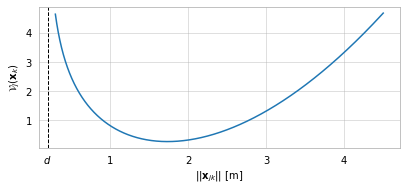

In [35]:
fig, ax = plt.subplots(
    1, 1, constrained_layout=True, figsize=(5.5, 2.5)
)
    
ax.set_axisbelow(True)
ax.plot(xs, potential)
#ax.set_ylim(ymin=-0.01)
#ax.set_ylim(ymax=4.5)
#ax.set_xlim(xmin=-0.01)
ax.set_xlabel('$||\mathbf{x}_{jk}||$ [m]')
ax.set_ylabel('$\mathcal{V}_j(\mathbf{x}_{k})$')
ax.axvline(0.2, color='black', ls='--', lw=1)
ticks = [0.2]
ax.set_xticks(ticks, minor=True)

dic = {
    0.2: '$d$',
}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
## or 
# labels = [dic.get(t, ticks[i]) for i,t in enumerate(ticks)]

ax.set_xticklabels(labels, minor=True)
#ax.tick_params(which='minor', labelbottom=True, labelrotation=-90)
#ax.axvline(0.3, color='black', ls='--')
#fig.savefig(f'/home/agniewek/repos/thesis/spatial_coordination/data/potential.pdf', transparent=True, bbox_inches='tight')
fig.savefig(f'/home/agniewek/repos/papers/2021-ABarcis-MRS-Swarming/data/potential.pdf', transparent=True, bbox_inches='tight')


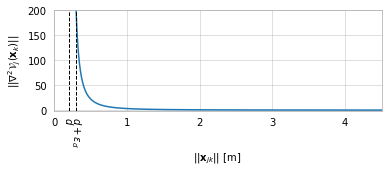

In [37]:
fig, ax = plt.subplots(
    1, 1, constrained_layout=False, figsize=(5.5, 2.5)
)
    
ax.set_axisbelow(True)
ax.plot(xs, lipschitz)
ax.set_ylim(ymin=-0.01)
ax.set_ylim(ymax=200)
ax.set_xlim(xmin=-0.01)
ax.set_xlim(xmax=4.5)
ax.set_xlabel('$||\mathbf{x}_{jk}||$ [m]')
ax.set_ylabel('$||∇^2\mathcal{V}_j(\mathbf{x}_{k})||$')
ax.axvline(0.2, color='black', ls='--', lw=1)
ax.axvline(0.3, color='black', ls='--', lw=1)
ticks = [0.2, 0.3]
ax.set_xticks(ticks, minor=True)

dic = {
    0.2: '$d$',
    0.3: '$d+\epsilon_d$',
}
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
## or 
# labels = [dic.get(t, ticks[i]) for i,t in enumerate(ticks)]

ax.set_xticklabels(labels, minor=True)
ax.tick_params(which='minor', labelbottom=True, labelrotation=-90)

plt.tight_layout()

fig.savefig(f'/home/agniewek/repos/thesis/spatial_coordination/data/lipschitz.pdf', transparent=True, bbox_inches='tight')

In [ ]:
exps = {
    '2021-03-04 13:24:50.559347:J=0,K=0,M=1,T=0.15.json': 'without,T=0.3',
    #'2021-03-04 13:26:54.742564:J=0,K=0,M=1,T=0.25.json': 'without,T=0.5',
    '2021-03-04 13:28:33.713132:J=0,K=0,M=1,T=0.5.json': 'without,T=1',
    '2021-03-04 13:29:11.724027:J=0,K=0,M=1,T=0.1.json': 'without,T=0.2',
    '2021-03-05 13:40:00.964232:J=0,K=0,M=1,T=0.15.json': 'with,T=0.3',
    #'2021-03-05 13:39:39.007336:J=0,K=0,M=1,T=0.25.json': 'with,T=0.5',
    '2021-03-05 13:40:28.783291:J=0,K=0,M=1,T=0.1.json': 'with,T=0.2',
    '2021-03-05 14:02:39.388270:J=0,K=0,M=1,T=0.5.json': 'with,T=1',
    '2021-04-26 16:17:02.355157:J=0,K=0,M=1,T=0.5.json': 'async',
    '2021-04-26 17:31:12.711957:J=0,K=0,M=1,T=2.5.json': 'async2',
}
maxt = {
    '2021-03-04 13:24:50.559347:J=0,K=0,M=1,T=0.15.json': 100,
    '2021-03-04 13:26:54.742564:J=0,K=0,M=1,T=0.25.json': 300,
    '2021-03-04 13:28:33.713132:J=0,K=0,M=1,T=0.5.json': 300,
    '2021-03-04 13:29:11.724027:J=0,K=0,M=1,T=0.1.json': 100,
    '2021-03-05 13:40:00.964232:J=0,K=0,M=1,T=0.15.json': 150,
    '2021-03-05 13:39:39.007336:J=0,K=0,M=1,T=0.25.json': 250,
    '2021-03-05 13:40:28.783291:J=0,K=0,M=1,T=0.1.json': 100,
    '2021-03-05 14:02:39.388270:J=0,K=0,M=1,T=0.5.json': 650,
    '2021-04-26 16:17:02.355157:J=0,K=0,M=1,T=0.5.json': 1000,
    '2021-04-26 17:31:12.711957:J=0,K=0,M=1,T=2.5.json': 10000,
}

In [ ]:
from utils.order_parameters import calculate_avg_dist
filenames_swarm = os.listdir(swarm_results_dir)
for filename in filenames_swarm: # exps.keys():
    print(filename)
    params = parse_params_from_filename(filename)
    with open(f'{swarm_results_dir}{filename}') as f:
        result = json.load(f)
        history = result['states']
        print(len(history))
        ts[filename] = []
        var_rs[filename] = []
        instants[filename] = []
        snapshots[filename] = {}
        potentials[filename] = []
        for t, states in history:
            for k, s in states.items():
                states[k] = state_from_json(s, params)
            #if t > maxt[filename]:
            #    break
            #if list(states.values())[0].small_phase == 0:
            ts[filename].append(t)
                # calculate new parameters
                # calculate_avg_dist(list(states.values()))
            var_rs[filename].append(calculate_avg_dist(list(states.values())))
            potentials[filename].append(calculate_potential(list(states.values())))
            snapshots[filename][t] = states
        times = ts[filename]
        instants[filename] = [times[-3], times[-2], times[-1]]  

In [ ]:
filenames_swarm = os.listdir(swarm_results_dir)
for filename in filenames_swarm:  # exps.keys():
    params = parse_params_from_filename(filename)
    fig, ax = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(5.5, 2.5)
    )
    fig, ax2 = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(5.5, 2.5)
    )
    print(len(ts[filename]))
    
    ax.set_title(params['T'])
#    ax.set_title(exps[filename])
    ax.set_axisbelow(True)
    #colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    #print(len(ts[filename]), len(var_rs[filename]))
    print(filename, var_rs[filename][-1])
    ax2.scatter(ts[filename][0:], var_rs[filename][0:], s=1, label="$V$")
    # ax.set_ylim(ymin=-0.01)
    for i, p in enumerate(list(zip(*potentials[filename]))):
        #print(len(p))
        #print(p)
        ax.scatter(ts[filename][-50:], p[-50:], s=10)
    #offsets = [ts[filename][-1]*0.01, ts[filename][-1]*0.03, ts[filename][-1]*0.12]
    ax.set_xlabel('time [s]')
    ax.set_ylabel('potential')

    #ax.legend(loc='center right')
    #ax.set_xlim((0, ts[filename][-1]))
    #fig.savefig(f'/home/agniewek/repos/thesis/spatial_coordination/data/sim-speedlimit-{exps[filename]}.pdf', transparent=True, bbox_inches="tight")
    #fig2.savefig(f'/home/agniewek/repos/papers/2020-journal/data/sim-snapshots-{pattern}.pdf', transparent=True, bbox_inches="tight")
    fig2, s = plt.subplots(1, 3, constrained_layout=True, figsize=(5.5, 2), sharex=True, sharey=True)
    for i, t in enumerate(instants[filename]):
        s[i].xaxis.set_major_locator(MultipleLocator(2))
        s[i].yaxis.set_major_locator(MultipleLocator(2))
        s[i].set_aspect('equal')
        xs = [s.position[0] for s in snapshots[filename][t].values()]
        ys = [s.position[1] for s in snapshots[filename][t].values()]
        cs = [colorsys.hsv_to_rgb((s.phase)%1, 1, 1) for s in snapshots[filename][t].values()]
        s[i].set_axisbelow(True)
        s[i].set_xlim((-5.1, 5.1))
        s[i].set_ylim((-5.1, 5.1))
        s[i].scatter(xs, ys, c=cs, s=30)
        s[i].set_title(f'$t={t:.0f}\\:$s')
        s[i].set_xlabel('[m]')
    

In [ ]:
async_results_dir = 'results/log/swarm/async/'
async_filenames = os.listdir(async_results_dir)
async_filenames.sort()
async_filenames

In [ ]:
async_files = [
    '2021-04-28 17:28:06.347950:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:28:28.745012:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:28:53.440962:J=0,K=0,M=1,T=0.01.json',
    '2021-04-28 17:29:18.848159:J=0,K=0,M=1,T=0.01.json',
]
for filename in async_files:
    print(filename)
    params = parse_params_from_filename(filename)
    with open(f'{async_results_dir}{filename}') as f:
        result = json.load(f)
        history = result['states']
        ts[filename] = []
        var_rs[filename] = []
        instants[filename] = []
        snapshots[filename] = {}
        potentials[filename] = []
        for t, states in history:
            for k, s in states.items():
                states[k] = state_from_json(s, params)
            #if t > maxt[filename]:
            #    break
            ts[filename].append(t)
            #if list(states.values())[0].small_phase == 0:
                # calculate new parameters
            #var_rs[filename].append(calculate_avg_dist(list(states.values())))
            # var_rs[filename].append(calculate_var_r(list(states.values())))
            snapshots[filename][t] = states
            
            potentials[filename].append(calculate_potential(list(states.values())))
            #print(list(states.values()))
            
        times = ts[filename]
        instants[filename] = [times[-2], times[-1]]

In [ ]:

for ident, filename in enumerate(async_files):
    titles = ['nothing', 'sync', 'speed', 'both']
    print(filename)
    params = parse_params_from_filename(filename)
    fig, ax = plt.subplots(
        1, 1, sharex=True, constrained_layout=True, figsize=(8, 4)
    )
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    ax.set_title(titles[ident])
    ax.set_axisbelow(True)
    #ax.scatter(ts[filename], var_rs[filename], s=1, label="$V$")
    #ax.scatter(ts[filename], angular_distances[filename], s=5, label="Angular distance diff")
    #ax.scatter(ts[filename], time_coord_potentials[filename], s=5, label="Time coordination potential")
    #ax.spines['left'].set_visible(False)
    #print(len(list(zip(*potentials[filename]))))
    #ax.scatter(ts[filename], list(zip(*potentials[filename]))[0])
    for i, p in enumerate(list(zip(*potentials[filename]))[-1:]):
        #print(len(p))
        #print(p)
        ax.scatter(ts[filename][-300:], p[-300:], c=colors[i], s=5)
    #ax.set_ylim(ymin=-0.01)
    #ax.set_ylim(ymax=0.01)
    #offsets = [ts[filename][-1]*0.01, ts[filename][-1]*0.03, ts[filename][-1]*0.12]
    ax.set_xlabel('time [s]')
    ax.set_ylabel('order parameter')

    #ax.legend(loc='center right')
    #ax.set_xlim((0, ts[filename][-1]))
    #fig.savefig(f'/home/agniewek/repos/thesis/spatial_coordination/data/sim-speedlimit-{exps[filename]}.pdf', transparent=True, bbox_inches="tight")
    #fig2.savefig(f'/home/agniewek/repos/papers/2020-journal/data/sim-snapshots-{pattern}.pdf', transparent=True, bbox_inches="tight")
    fig2, s = plt.subplots(1, 2, constrained_layout=True, figsize=(8, 4), sharex=True, sharey=True)
    for i, t in enumerate(instants[filename]):
        s[i].xaxis.set_major_locator(MultipleLocator(2))
        s[i].yaxis.set_major_locator(MultipleLocator(2))
        #s[i].set_aspect('equal')
        xs = [s.position[0] - 1 * t for s in snapshots[filename][t].values()]
        ys = [s.position[1] for s in snapshots[filename][t].values()]
        distances = []
        for k in range(len(xs)):
            for j in range(k+1, len(xs)):
                distances.append(np.linalg.norm([xs[k]-xs[j], ys[k] - ys[j]]))
                
        print(min(distances))
        #print('var', var_rs[filename][-1])
                
        cs = [colorsys.hsv_to_rgb((s.phase)%1, 1, 1) for s in snapshots[filename][t].values()]
        s[i].set_axisbelow(True)
        s[i].axis('square')
        #s[i].set_xlim((-5.1, 5.1))
        #s[i].set_ylim((-5.1, 5.1))
        s[i].scatter(xs, ys, c=cs, s=80)
        s[i].set_title(f'$t={t:.0f}\\:$s')
        s[i].set_xlabel('[m]')
        
    fig.savefig(f'/tmp/plot-order-{titles[ident]}.png', transparent=True, bbox_inches="tight")
    fig2.savefig(f'/tmp/plot-pattern-{titles[ident]}.png', transparent=True, bbox_inches="tight")

In [ ]:
filename = '2021-03-04 13:24:50.559347:J=0,K=0,M=1,T=0.15.json'
with open(f'{swarm_results_dir}{filename}') as f:
    result = json.load(f)
    history = result['states']
    #print(history[-10:])
    print([s['small_phase'] for s in history[-3][1].values()])
    print([s['small_phase'] for s in history[-2][1].values()])
    print([s['small_phase'] for s in history[-1][1].values()])
    print(history[-1][1].keys())
print(var_rs[filename][-10:])